-------- > epoch 1:  coût moyen entraînement = 0.2226230800151825
-------- > epoch 1:  taux moyen entraînement = 0.9424409866333008
-------- > epoch 1:  coût moyen validation = 0.08416076004505157
-------- > epoch 1:  taux moyen validation = 0.9766004085540771
-------- > epoch 2:  coût moyen entraînement = 0.08485463261604309
-------- > epoch 2:  taux moyen entraînement = 0.974860429763794
-------- > epoch 2:  coût moyen validation = 0.06491212546825409
-------- > epoch 2:  taux moyen validation = 0.9815001487731934
-------- > epoch 3:  coût moyen entraînement = 0.05850937217473984
-------- > epoch 3:  taux moyen entraînement = 0.982160210609436
-------- > epoch 3:  coût moyen validation = 0.04196846857666969
-------- > epoch 3:  taux moyen validation = 0.9868001341819763
-------- > epoch 4:  coût moyen entraînement = 0.04461425170302391
-------- > epoch 4:  taux moyen entraînement = 0.9863601326942444
-------- > epoch 4:  coût moyen validation = 0.03652643784880638
-------- > epoch 4:

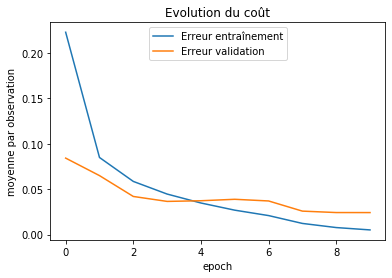

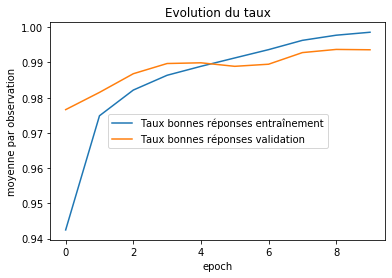

In [5]:
%matplotlib inline
# -*- coding: utf-8 -*-
"""
Exemple de MNIST avec PyTorch
Exemple avec connexion distante (BlocResSimple)
"""
import torch
torch.manual_seed(0) # Pour résultats reproductibles

# Fonction J d'entropie croisée
import torch.nn.functional as F
fonction_cout = F.cross_entropy

def taux_bonnes_predictions(lot_Y_predictions, lot_Y):
    predictions_categorie = torch.argmax(lot_Y_predictions, dim=1)
    return (predictions_categorie == lot_Y).float().mean()

from torch import nn
# Définition de l'architecture du RNA

class BlocResSimple(nn.Module):
    def __init__(self, nb_f):
        super().__init__()
        self.convolution = nn.Conv2d(nb_f, nb_f, kernel_size=3, stride=1, padding=1) 
        self.normalisation = nn.BatchNorm2d(nb_f)    

    def forward(self, lot_X):
        lot_Y_predictions = self.convolution(lot_X)
        lot_Y_predictions = self.normalisation(lot_Y_predictions)
        lot_Y_predictions = F.relu(lot_Y_predictions)
        return lot_Y_predictions+lot_X
    
class BlocResNetSimple(nn.Module):
    def __init__(self, nb_f):
        super().__init__()

        self.conv1 = nn.Conv2d(nb_f, nb_f, kernel_size=3, stride=1, padding=1, bias=False) 
        self.bn1 = nn.BatchNorm2d(nb_f)    
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(nb_f, nb_f, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(nb_f)    

    def forward(self, lot_X):
        lot_Y_predictions = self.conv1(lot_X)
        lot_Y_predictions = self.bn1(lot_Y_predictions)
        lot_Y_predictions = self.relu(lot_Y_predictions)
        lot_Y_predictions = self.conv2(lot_Y_predictions)
        lot_Y_predictions = self.bn2(lot_Y_predictions)
        lot_Y_predictions = lot_Y_predictions + lot_X
        lot_Y_predictions = self.relu(lot_Y_predictions)
        return lot_Y_predictions 

modele = nn.Sequential(
    nn.Conv2d(1,8,3,2,1),
    nn.BatchNorm2d(8),
    nn.ReLU(),
    BlocResNetSimple(8),
    nn.Conv2d(8,16,3,2,1),
    nn.BatchNorm2d(16),
    nn.ReLU(),    
    BlocResNetSimple(16),
    nn.Conv2d(16,32,3,2,1),
    nn.BatchNorm2d(32),
    nn.ReLU(),    
    BlocResNetSimple(32),
    nn.Conv2d(32,16,3,2,1),
    nn.BatchNorm2d(16),
    nn.ReLU(),
    nn.Conv2d(16,10,3,2,1),
    nn.BatchNorm2d(10),
    nn.ReLU(),
    nn.Flatten()
#    nn.Linear(20*20*16,10)
)

from torch import optim
optimiseur = optim.SGD(modele.parameters(), lr=0.5, momentum=0.9)

# Chargement des données de MNIST
import pickle, gzip
fichier_donnees = gzip.open(r"mnist.pkl.gz", 'rb')
((donnees_ent_X, donnees_ent_Y),(donnees_valid_X, donnees_valid_Y),(donnees_test_X,donnees_test_Y)) = pickle.load(fichier_donnees, encoding="latin-1")
fichier_donnees.close()

# Conversion des données en type toch.Tensor
import torch
donnees_ent_X,donnees_ent_Y,donnees_valid_X,donnees_valid_Y,donnees_test_X,donnees_test_Y  = map(torch.tensor,
    (donnees_ent_X.reshape((-1,1,28,28)),donnees_ent_Y,donnees_valid_X.reshape((-1,1,28,28)),donnees_valid_Y,donnees_test_X.reshape((-1,1,28,28)),donnees_test_Y))

# Création des objets DataLoader pour itérer par lot
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
ds_ent = TensorDataset(donnees_ent_X, donnees_ent_Y)
dl_ent = DataLoader(ds_ent, batch_size=100, shuffle=True)
ds_valid = TensorDataset(donnees_valid_X,donnees_valid_Y)
dl_valid = DataLoader(ds_valid, batch_size=100)

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimiseur, 
                                                max_lr=0.5, 
                                                steps_per_epoch=len(dl_ent),
                                                epochs=10)

def entrainer(modele, dl_ent, dl_valid, optimiseur,scheduler, nb_epochs=10):

    # Listes pour les métriques par epoch
    liste_cout_moyen_ent = []
    liste_taux_moyen_ent = []
    liste_cout_moyen_valid = []
    liste_taux_moyen_valid = []
    
    # Boucle d'apprentissage
    for epoch in range(nb_epochs):
        cout_total_ent = 0 # pour cumuler les couts par mini-lot
        taux_bonnes_predictions_ent = 0 # pour cumuler les taux par mini-lot
        modele.train() # Pour certains types de couches (nn.BatchNorm2d, nn.Dropout, ...)
        
        # Boucle d'apprentissage par mini-lot pour une epoch
        for lot_X, lot_Y in dl_ent:
            optimiseur.zero_grad() # Remettre les dérivées à zéro
            lot_Y_predictions = modele(lot_X) # Appel de la méthode forward
            cout = fonction_cout(lot_Y_predictions, lot_Y)
            cout.backward() # Calcul des gradiants par rétropropagation
            with torch.no_grad():
                cout_total_ent +=cout
                taux_bonnes_predictions_ent += taux_bonnes_predictions(lot_Y_predictions, lot_Y)
            optimiseur.step() # Mise à jour des paramètres
            scheduler.step()
        # Calculer les moyennes par mini-lot
        with torch.no_grad():
            cout_moyen_ent = cout_total_ent/len(dl_ent)
            taux_moyen_ent = taux_bonnes_predictions_ent/len(dl_ent)
       
        modele.eval() # Pour certains types de couches (nn.BatchNorm2d, nn.Dropout, ...)
        with torch.no_grad():
            cout_valid = sum(fonction_cout(modele(lot_valid_X), lot_valid_Y) for lot_valid_X, lot_valid_Y in dl_valid)
            taux_bons_valid = sum(taux_bonnes_predictions(modele(lot_valid_X), lot_valid_Y) for lot_valid_X, lot_valid_Y in dl_valid)
        cout_moyen_valid = cout_valid/len(dl_valid)
        taux_moyen_valid = taux_bons_valid/len(dl_valid)
        print(f'-------- > epoch {epoch+1}:  coût moyen entraînement = {cout_moyen_ent}')
        print(f'-------- > epoch {epoch+1}:  taux moyen entraînement = {taux_moyen_ent}')
        print(f'-------- > epoch {epoch+1}:  coût moyen validation = {cout_moyen_valid}')
        print(f'-------- > epoch {epoch+1}:  taux moyen validation = {taux_moyen_valid}')
    
        liste_cout_moyen_ent.append(cout_moyen_ent)
        liste_taux_moyen_ent.append(taux_moyen_ent)
        liste_cout_moyen_valid.append(cout_moyen_valid)
        liste_taux_moyen_valid.append(taux_moyen_valid)
    
    # Affichage du graphique d'évolution des métriques par epoch
    import numpy as np
    import matplotlib.pyplot as plt
    plt.plot(np.arange(0,nb_epochs),liste_cout_moyen_ent,label='Erreur entraînement')
    plt.plot(np.arange(0,nb_epochs),liste_cout_moyen_valid,label='Erreur validation')
    plt.title("Evolution du coût")
    plt.xlabel('epoch')
    plt.ylabel('moyenne par observation')
    plt.legend(loc='upper center')
    plt.show()
        
    plt.plot(np.arange(0,nb_epochs),liste_taux_moyen_ent,label='Taux bonnes réponses entraînement')
    plt.plot(np.arange(0,nb_epochs),liste_taux_moyen_valid,label='Taux bonnes réponses validation')
    plt.title("Evolution du taux")
    plt.xlabel('epoch')
    plt.ylabel('moyenne par observation')
    plt.legend(loc='center')
    plt.show()

entrainer(modele, dl_ent, dl_valid, optimiseur,scheduler, nb_epochs=10)